# NERD Visualization Notebook

Set `nerd_sqlite` to the SQLite database that contains your pipeline results before running the analysis cells below.

In [1]:
import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import display

plt.style.use("seaborn-v0_8-paper")

In [2]:
# Test imports to see if the compatibility issues are resolved
try:
    import statsmodels.api as sm
    print("✓ Statsmodels import successful")
except ImportError as e:
    print(f"✗ Statsmodels import failed: {e}")

try:
    import pymc as pm
    print("✓ PyMC import successful")
except ImportError as e:
    print(f"✗ PyMC import failed: {e}")
    
try:
    import arviz as az
    print("✓ ArviZ import successful")
except ImportError as e:
    print(f"✗ ArviZ import failed: {e}")

✓ Statsmodels import successful
✗ PyMC import failed: No module named 'pymc'
✗ ArviZ import failed: No module named 'arviz'


In [3]:
# Check the actual Python executable and environment being used
import sys
import os
print(f"Python executable: {sys.executable}")
print(f"Python path: {sys.path[:3]}...")  # Show first few paths
print(f"Current working directory: {os.getcwd()}")

# Check if we can see what conda environment is active
if 'CONDA_DEFAULT_ENV' in os.environ:
    print(f"Conda environment: {os.environ['CONDA_DEFAULT_ENV']}")
elif 'CONDA_PREFIX' in os.environ:
    print(f"Conda prefix: {os.environ['CONDA_PREFIX']}")
else:
    print("No conda environment detected")

Python executable: /opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/bin/python
Python path: ['/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python311.zip', '/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11', '/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/lib-dynload']...
Current working directory: /Volumes/MiniVault/LucksLab Dropbox/LucksLab/Group_Members/EKC/Projects/EKC.07.nerd/Choi_HDX_Chemprobing_2025/Core_nerd_analysis
Conda environment: data_analysis


## Put your nerd sqlite file directory below

In [4]:
nerd_sqlite = 'nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

## 1. View created samples and metadata

Explore buffers, constructs, sequencing runs, and sequencing samples loaded into the database. Adjust the queries if you need additional columns.


In [5]:
# SQL queries for various tables
tables = {
    "meta_buffers": """
        SELECT id, name, disp_name, pH, composition
        FROM meta_buffers
        ORDER BY id
    """,
    "meta_constructs": """
        SELECT id, family, name, version, disp_name
        FROM meta_constructs
        ORDER BY id
    """,
    "meta_nucleotides": """
        SELECT *
        FROM meta_nucleotides
        ORDER BY id
    """,
    "sequencing_runs": """
        SELECT id, run_name, date, sequencer, run_manager
        FROM sequencing_runs
        ORDER BY date DESC, id DESC
    """,
    "sequencing_samples": """
        SELECT id, sample_name, fq_dir
        FROM sequencing_samples
        ORDER BY id
    """,
}

### Buffers

In [6]:
read_sql(tables.get('meta_buffers', ""))

,id,name,disp_name,pH,composition
0,1,Schwalbe_bistris,pH6.5_A,6.5,"150 mM bis-tris, 15 mM Kx(HPO4)y, 25 mM KCl"
1,2,P4P6_bicine_NoMg,pH8_noMg,8.0,"200 mM bicine, 100 mM KCl"
2,3,P4P6_bicine_5mMMg,pH8_5mMMg,8.0,"200 mM bicine, 100 mM KCl, 5 mM MgCl2"
3,4,AlHashimiLab_NMR_NoMg_v2,pH6.5_B,6.4,"150 mM bis-tris, 15 mM Na3PO4, 25 mM NaCl, 0.1..."


### Constructs

In [7]:
read_sql(tables.get('meta_constructs', ""))

,id,family,name,version,disp_name
0,1,HIV-1_TAR,A35G,2,hiv_a35g
1,2,HIV-1_TAR,C30U,2,hiv_c30u
2,3,HIV-1_TAR,UUCG_ES2,1,hiv_es2
3,4,HIV-1_TAR,UUCG_GS,2,hiv_gs
4,5,HIV-1_TAR,WT,2,hiv_wt
5,6,Salm_4U_thermometer,WT,2,4U_wt
6,7,Salm_4U_thermometer,A8C,2,4U_a8c
7,8,P4P6_full,WT,1,p4p6_wt
8,9,P4P6_full,WT,2,p4p6_wt_nobc


In [8]:
read_sql(tables.get('meta_nucleotides', ""))

,id,construct_id,site,base,base_region
0,1,1,-18,G,0
1,2,1,-17,G,0
2,3,1,-16,C,0
3,4,1,-15,A,0
4,5,1,-14,C,0
...,...,...,...,...,...
978,979,9,285,C,2
979,980,9,286,A,2
980,981,9,287,A,2
981,982,9,288,C,2


### Sequencing runs

In [9]:
read_sql(tables.get('sequencing_runs', ""))

,id,run_name,date,sequencer,run_manager
0,22,250208_VH01990_20_AAGN23LM5,250208,NextSeq,EKC
1,21,240424_Lucks24_fourU_DMS_BATCH5-6,240424,NovaSeq,EKC
2,20,240424_Lucks23_fourU_DMS_BATCH3-4,240424,NovaSeq,EKC
3,19,240405_M05164_0164_000000000-LH62L,240405,MiSeq,EKC
4,18,230901_M05164_0153_000000000-L6FR8,230901,MiSeq,EKC
5,17,230831_M05164_0151_000000000-L642V,230831,MiSeq,EKC
6,16,230830_M05164_0150_000000000-L6463,230830,MiSeq,EKC
7,15,230617_M05164_0145_000000000-L4LWB,230617,MiSeq,EKC
8,14,230607_M05164_0144_000000000-L3FLD,230607,MiSeq,EKC
9,13,230606_M05164_0143_000000000-GHJVD,230606,MiSeq,EKC


### Sequencing samples

In [10]:
read_sql(tables.get('sequencing_samples', ""))

,id,sample_name,fq_dir
0,1,001-EKC-fourUnew-WT-II-37C-dms-stop-0-30,/projects/b1044/Sequencing/SHAPE-Seq/EKC/22112...
1,2,002-EKC-fourUnew-WT-II-37C-dms-stop-1,/projects/b1044/Sequencing/SHAPE-Seq/EKC/22112...
2,3,003-EKC-fourUnew-WT-II-37C-dms-stop-20,/projects/b1044/Sequencing/SHAPE-Seq/EKC/22112...
3,4,004-EKC-fourUnew-WT-II-37C-dms-stop-40,/projects/b1044/Sequencing/SHAPE-Seq/EKC/22112...
4,5,005-EKC-fourUnew-WT-II-37C-dms-stop-60,/projects/b1044/Sequencing/SHAPE-Seq/EKC/22112...
...,...,...,...
1126,1127,068_P4P6_WT_nobc_0mMMgMRTpH9_conc3_rep1,/projects/b1044/Sequencing/SHAPE-Seq/EKC/25020...
1127,1128,069_P4P6_WT_nobc_0mMMgMRTpH9_conc0_rep2,/projects/b1044/Sequencing/SHAPE-Seq/EKC/25020...
1128,1129,070_P4P6_WT_nobc_0mMMgMRTpH9_conc0p75_rep2,/projects/b1044/Sequencing/SHAPE-Seq/EKC/25020...
1129,1130,071_P4P6_WT_nobc_0mMMgMRTpH9_conc1p5_rep2,/projects/b1044/Sequencing/SHAPE-Seq/EKC/25020...


## 2. Modification rate ($f_{\text{mod}}$) calculation runs

This section inspects mutation-rate outputs per `probe_fmod_run`. Start by listing available runs, then set the identifiers below to produce bar plots aggregated by nucleotide (`site_base`).


In [11]:
fmod_runs = read_sql(
    """
    SELECT
        fr.id AS fmod_run_id,
        fr.software_name,
        fr.software_version,
        fr.run_datetime,
        COUNT(DISTINCT fv.nt_id) AS unique_nts,
        COUNT(DISTINCT fv.rxn_id) AS reactions,
        GROUP_CONCAT(DISTINCT fv.valtype) AS valtypes
    FROM probe_fmod_runs fr
    LEFT JOIN probe_fmod_values fv ON fv.fmod_run_id = fr.id
    GROUP BY fr.id
    ORDER BY fr.run_datetime DESC, fr.id DESC
    """
)

if fmod_runs.empty:
    print("No probe_fmod_runs found in the database.")
else:
    display(fmod_runs)


,fmod_run_id,software_name,software_version,run_datetime,unique_nts,reactions,valtypes
0,1053,shapemapper,v2.3.0,2025-10-14 18:26:44,80,1,"GAmodrate,modrate"
1,1052,shapemapper,v2.3.0,2025-10-14 18:25:59,80,1,"GAmodrate,modrate"
2,1051,shapemapper,v2.3.0,2025-10-14 18:25:46,80,1,"GAmodrate,modrate"
3,1029,shapemapper,v2.3.0,2025-10-14 18:24:40,80,1,"GAmodrate,modrate"
4,1050,shapemapper,v2.3.0,2025-10-14 18:23:48,80,1,"GAmodrate,modrate"
...,...,...,...,...,...,...,...
1048,5,shapemapper,v2.3.0,2025-10-14 13:33:10,212,1,"GAmodrate,modrate"
1049,4,shapemapper,v2.3.0,2025-10-14 13:33:09,212,1,"GAmodrate,modrate"
1050,3,shapemapper,v2.3.0,2025-10-14 13:33:08,212,1,"GAmodrate,modrate"
1051,2,shapemapper,v2.3.0,2025-10-14 13:33:07,212,1,"GAmodrate,modrate"


In [12]:
def barplot_fmod_values(selected_fmod_run_id, selected_valtype=None, selected_sample=None):
    """Generate bar plots of fmod values for a given probe_fmod_run ID."""
    data = read_sql(
        """
        SELECT
            fv.fmod_run_id,
            fv.valtype,
            fv.fmod_val,
            s.sample_name,
            mn.site,
            mn.base,
            mn.site || '_' || UPPER(mn.base) AS site_base
        FROM probe_fmod_values fv
        JOIN probe_reactions pr ON pr.id = fv.rxn_id
        JOIN sequencing_samples s ON s.id = pr.s_id
        JOIN meta_nucleotides mn ON mn.id = fv.nt_id
        WHERE fv.fmod_run_id = :run_id
        ORDER BY s.sample_name, mn.site
        """,
        {"run_id": selected_fmod_run_id},
    )

    if data.empty:
        print("No mutation-rate rows found for that run id.")
    else:
        if selected_valtype:
            data = data[data["valtype"] == selected_valtype]
        if selected_sample:
            data = data[data["sample_name"] == selected_sample]

        if data.empty:
            print("Filters removed all rows. Adjust selections.")
        else:
            summary = (
                data.groupby(["sample_name", "site_base"], as_index=False)["fmod_val"].mean()
            )
            fig, ax = plt.subplots(figsize=(8, 3))
            for sample, group in summary.groupby("sample_name"):
                group_sorted = group.sort_values("site_base")
                ax.bar(
                    group_sorted["site_base"],
                    group_sorted["fmod_val"],
                    label=sample,
                    alpha=0.6,
                )
            ax.set_title(
                f"Probe mutation rates for run {selected_fmod_run_id}"
                + (f" – {selected_valtype}" if selected_valtype else "")
            )
            ax.set_xlabel("Sequence (site_base)")
            ax.set_ylabel(r'$f_{\text{mod}}$')
            ax.legend(loc="upper right")
            plt.setp(ax.get_xticklabels(), rotation=90)
            plt.tight_layout()

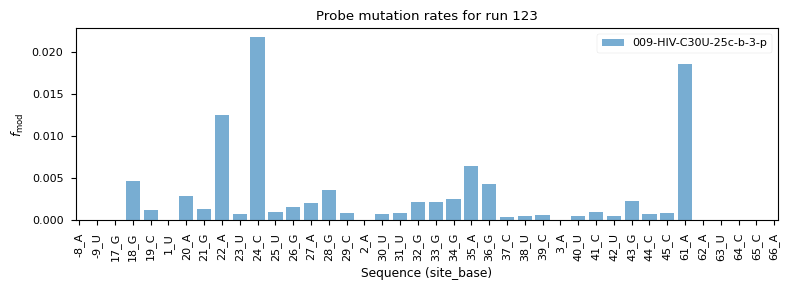

In [13]:
barplot_fmod_values(123)

## 3. Timecourse fits by reaction group

Use this section to scatter plot mutation rates across reaction times for a specific reaction group and nucleotide, then estimate a simple first-order kinetic fit.


In [14]:
rg_listing = read_sql(
    """
    SELECT
        pr.rg_id,
        prg.rg_label,
        COUNT(DISTINCT pr.s_id) AS samples,
        COUNT(DISTINCT fv.nt_id) AS nts,
        GROUP_CONCAT(DISTINCT fv.valtype) AS valtypes
    FROM probe_reactions pr
    JOIN probe_reaction_groups prg ON prg.rg_id = pr.rg_id
    LEFT JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
    GROUP BY pr.rg_id
    ORDER BY pr.rg_id
    """
)

if rg_listing.empty:
    print("No reaction groups with mutation rates found.")
else:
    display(rg_listing)


,rg_id,rg_label,samples,nts,valtypes
0,1,37_1,8,0,None
1,2,37_2_A8C,48,0,None
2,3,37_2,40,80,"GAmodrate,modrate"
3,4,37_3,8,0,None
4,5,37_1_A8C,8,0,None
...,...,...,...,...,...
129,130,14,7,212,"GAmodrate,modrate"
130,131,15,7,241,"GAmodrate,modrate"
131,132,16,7,241,"GAmodrate,modrate"
132,133,17,4,212,"GAmodrate,modrate"


In [15]:
def plot_timecourse(selected_rg_id, selected_site_base, selected_valtype_tc, ax):
    """Plot timecourse data and fitted curve for a given reaction group and nucleotide."""

    def _fmod_model(x: np.ndarray, log_kappa: float, log_kdeg: float, log_fmod_0: float) -> np.ndarray:
        kappa = np.exp(log_kappa)     # == kobs
        kdeg  = np.exp(log_kdeg)
        fmod0 = np.exp(log_fmod_0)
        return 1.0 - np.exp(-kappa * (1.0 - np.exp(-kdeg * x))) + fmod0

    if selected_rg_id is None or not selected_site_base:
        print("Set both `selected_rg_id` and `selected_site_base` to proceed.")
    else:
        timecourse_df = read_sql(
            """
            SELECT
                pr.rg_id,
                pr.reaction_time,
                pr.treated,
                pr.temperature,
                pr.replicate,
                pr.buffer_id,
                fv.fmod_val,
                fv.valtype,
                mn.site,
                mn.base,
                mn.site || '_' || UPPER(mn.base) AS site_base,
                s.sample_name,
                fv.outlier AS outlier,
                s.to_drop AS to_drop
            FROM probe_reactions pr
            JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
            JOIN meta_nucleotides mn ON mn.id = fv.nt_id
            JOIN sequencing_samples s ON s.id = pr.s_id
            WHERE pr.rg_id = :rg_id
            AND mn.site || '_' || UPPER(mn.base) = :site_base
            AND fv.valtype = :valtype
            ORDER BY pr.reaction_time
            """,
            {"rg_id": selected_rg_id, "site_base": selected_site_base, "valtype": selected_valtype_tc},
        )

        temperature = timecourse_df["temperature"].iloc[0] if not timecourse_df.empty else None
        replicate = timecourse_df["replicate"].iloc[0] if not timecourse_df.empty else None

        fit_params_df = read_sql(
            """
            WITH run AS (
            SELECT id AS fit_run_id
            FROM probe_tc_fit_runs
            WHERE (rg_id, nt_id) IN (
                SELECT DISTINCT pr.rg_id, mn.id
                FROM probe_reactions pr
                JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
                JOIN meta_nucleotides mn ON mn.id = fv.nt_id
                WHERE pr.rg_id = :rg_id
                AND mn.site || '_' || UPPER(mn.base) = :site_base
            )
            AND fit_kind = 'round3_constrained'
            AND valtype = :valtype_mod
            )
            SELECT
            p.fit_run_id,
            MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')    THEN p.param_numeric END) AS log_kobs,
            MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')    THEN p.param_numeric END) AS log_kdeg,
            MAX(CASE WHEN p.param_name IN ('log_fmod0','logfmod0')  THEN p.param_numeric END) AS log_fmod0,
            MAX(CASE WHEN p.param_name =  'kobs'                    THEN p.param_numeric END) AS kobs,
            MAX(CASE WHEN p.param_name =  'kdeg'                    THEN p.param_numeric END) AS kdeg,
            MAX(CASE WHEN p.param_name =  'fmod0'                   THEN p.param_numeric END) AS fmod0,
            MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')    THEN p.param_numeric END) AS log_kobs_err,
            MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')    THEN p.param_numeric END) AS log_kdeg_err,
            MAX(CASE WHEN p.param_name IN ('log_fmod0_err','logfmod0_err')  THEN p.param_numeric END) AS log_fmod0_err,
            MAX(CASE WHEN p.param_name =  'diag:r2'                 THEN p.param_numeric END) AS diag_r2
            FROM probe_tc_fit_params p
            JOIN run r ON r.fit_run_id = p.fit_run_id
            GROUP BY p.fit_run_id
            """,
            {"rg_id": selected_rg_id, "site_base": selected_site_base, "valtype_mod": selected_valtype_tc},
        )

        if timecourse_df.empty:
            print("No timecourse rows matched those filters.")
        else:
            treated = timecourse_df[timecourse_df["treated"] != 0].copy()
            control = timecourse_df[timecourse_df["treated"] == 0].copy()
            control["reaction_time"] = 0.0

            def _pick_color(row):
                outlier_flag = row.get("outlier", 0)
                to_drop_flag = row.get("to_drop", 0)
                try:
                    if int(outlier_flag):
                        return "orange"
                except (TypeError, ValueError):
                    pass
                try:
                    if int(to_drop_flag):
                        return "red"
                except (TypeError, ValueError):
                    pass
                return "tab:blue"
            control_colors = [_pick_color(row) for _, row in control.iterrows()] if not control.empty else []
            treated_colors = [_pick_color(row) for _, row in treated.iterrows()] if not treated.empty else []

            if not control.empty:
                ax.scatter(
                    control["reaction_time"], control["fmod_val"],
                    c=control_colors, marker="x", label="control"
                )
            if not treated.empty:
                ax.scatter(
                    treated["reaction_time"], treated["fmod_val"],
                    c=treated_colors, marker="o", label="treated"
                )
            else:
                print("No treated timepoints available for kinetic fitting.")

            # ---- build and add fitted curve if params exist ----
            if len(fit_params_df) >0:
                # choose best run if multiple (highest R^2)
                best = fit_params_df.sort_values("diag_r2", ascending=False).iloc[0]
                log_kobs  = float(best["log_kobs"])
                log_kdeg  = float(best["log_kdeg"])
                log_fmod0 = float(best["log_fmod0"])

                # x_fit domain from observed times (fall back to 0..max if needed)
                x_min = 0.0
                x_max = float(timecourse_df["reaction_time"].max())
                if x_min == x_max:
                    x_min, x_max = 0.0, max(1.0, x_max)

                x_fit = np.linspace(x_min, x_max, 200)
                y_fit = _fmod_model(x_fit, log_kobs, log_kdeg, log_fmod0)

                ax.plot(x_fit, y_fit, label=f"fit (R²={best['diag_r2']:.3f})", color = 'black')

            ax.set_title(
                f"rg_id {selected_rg_id} – {selected_site_base} - Temperature: {temperature}°C, Replicate: {replicate}"
                + (f" – {selected_valtype_tc}" if selected_valtype_tc else "")
            )
            ax.set_xlabel("Reaction time (s)")
            ax.set_ylabel("fmod value")
            handles, labels = ax.get_legend_handles_labels()
            drop_present = (not treated.empty and treated["to_drop"].astype(int).eq(1).any()) or (not control.empty and control["to_drop"].astype(int).eq(1).any())
            if drop_present:
                handles.append(Line2D([], [], color="red", marker="o", linestyle="", label="to_drop = 1"))
                labels.append("to_drop = 1")
            if handles:
                ax.legend(handles=handles, labels=labels, loc="best")
    return timecourse_df, fit_params_df, ax

,rg_id,sample_name
0,67,049_fourU_A8C_25c_a_1_p
1,67,050_fourU_A8C_25c_a_2_p
2,67,051_fourU_A8C_25c_a_3_p
3,67,052_fourU_A8C_25c_a_4_p
4,67,053_fourU_A8C_25c_a_5_p
5,67,054_fourU_A8C_25c_a_6_p
6,67,073_fourU_A8C25c_a_2_p
7,67,076_fourU_A8C25c_a_6_m


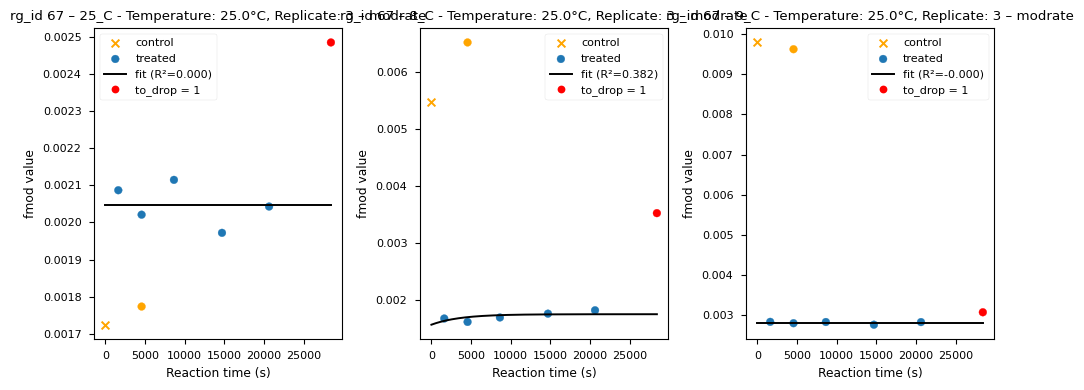

In [28]:
conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

selected_rg_id = 67                 # e.g., 8

selected_site_base = '25_C'          # e.g., '7_A'
selected_valtype_tc = 'modrate'     # e.g., 'modrate' or None for all

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

selected_site_base_GA = '8_C'          # e.g., '7_A'
selected_valtype_tc_GA = 'modrate'     # e.g., 'modrate' or None for all

selected_site_base_G = '9_C'
selected_valtype_tc_G = 'modrate'

tc, fit, axs[0] = plot_timecourse(selected_rg_id, selected_site_base, selected_valtype_tc, axs[0])
tc, fit, axs[1] = plot_timecourse(selected_rg_id, selected_site_base_GA, selected_valtype_tc_GA, axs[1])
tc, fit, axs[2] = plot_timecourse(selected_rg_id, selected_site_base_G, selected_valtype_tc_G, axs[2])

plt.tight_layout()

rg_samples = read_sql(
    f"""
    SELECT pr.rg_id, s.sample_name
    FROM probe_reactions pr
    JOIN sequencing_samples s ON s.id = pr.s_id
    WHERE pr.rg_id = {selected_rg_id}
    """
)
display(rg_samples)
conn.close()

## 4. Temperature Gradient Analysis (TODO)

Placeholder for future temperature-gradient visualizations once the underlying queries are defined.
